# **Titaninc Top 4% with ensemble modeling**
**Yassine Ghouzam, PhD**

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

##**1. Introduction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

##**2. Load and check data**

###**2.1 Load data**

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Connection/Kaggle 필사/titanic_update/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Connection/Kaggle 필사/titanic_update/test.csv")
IDtest = test["PassengerId"]

###**2.2 Outlier detection**

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

- 이상 값은 예측에 극적인 영향을 미칠 수 있기 때문에 (특히 회귀 문제의 경우) 이를 관리하기로 결정하였다.

- Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값(IQR)의 1사분면과 3사분면 사이로 구성된 4분면 범위를 정의하는 outlier를 탐지했다. 이상 값은 (IQR +- 이상 값 단계) 외부에 특성 값이 있는 행이다.

- Numerical 값 특성(Age, SibSp, Parch 및 Fare)에서 이상 값을 감지하기로 결정했다. 그런 다음 이상 값을 최소한 두 개의 이상 숫자 갑이 있는 행으로 간주했다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 이상 값 10개를 감지했다. 28, 89 및 342 승객의 티켓 요금이 높다.

- 나머지 7개는 SibSp의 값이 매우 높다.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

###**2.3 joining train and test set**

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

- Train 및 test datasets를 결합하여 범주 변환 중에 동일한 수의 특성을 얻는다. (See feature engineering)

###**2.4 check for null and missing values**

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age 및 Cabin 특성은 결측값의 중요한 부분을 가지고 있다. 

- **생존 결측값은 join testing dataset에 해당한다. (Survived 열은 test set에 존재하지 않으며 train set와 test set를 연결할 때 NaN 값으로 대체된다.)**

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


##**3. Feature analysis**

###**3.1 Numerical values**

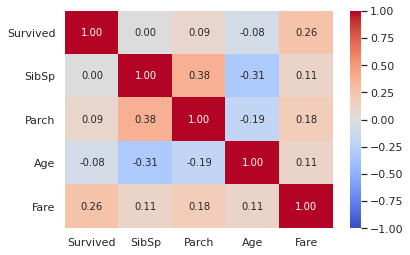

In [38]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, center=0)

- Fare 특성만이 생존 확률과 유의한 상관 관계를 갖는 것으로 보인다.

- 다른 특성이 유용하지 않다는 의미는 아니다. 이러한 특성의 하위 집단은 생존과 상관 관계가 있을 수 있다. 이를 확인하기 위해 이러한 특성을 자세히 살펴보아야 한다.

> SibSp

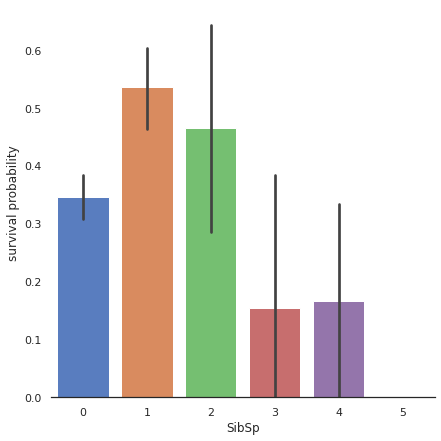

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 형제 자매 / 배우자가 많은 승객은 생존할 기회가 적은 것 같다.

- 단일 승객(0 SibSp) 또는 다른 두 사람(SibSp 1 또는 2)과 함께 있는 경우 생존 가능성이 더 높다.

- 이 관찰은 매우 흥미롭다. 이러한 범주를 설명하는 새로운 기능을 고려할 수 있다. (See feature engineering)

> Parch

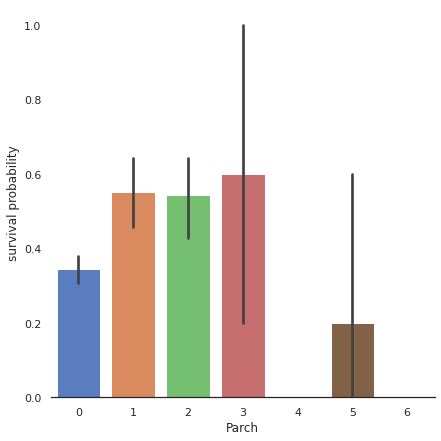

In [14]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 소규모 가족은 독신(Parch 0), 중형(Parch 3, 4) 및 대가족(Parch 5, 6)보다 생존할 기회가 더 많다.

- 부모 / 자녀가 3명인 승객의 생존율에는 중요한 표준 편차가 있으므로 주의해야 한다.

> Age

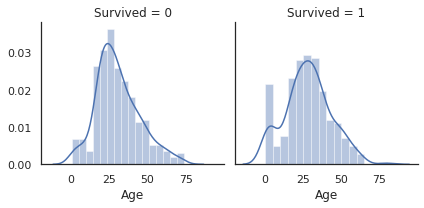

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

- 연령 분포는 tailed distribution, gaussian distribution인 것 같다.

- 생존한 하위 집단과 생존하지 않은 하위 집단에서 연령 분포가 동일하지 않다는 것을 볼 수 있다. 실제로 살아남은 젊은 승객에 해당하는 peak가 있다. 또한 60-80세 사이의 승객들이 덜 살아남은 것을 볼 수 있다.

- 따라서 "Age"이 "Survived"와 상관 관계가 없는 경우에도 생존 가능성이 어느 정도 있는 승객의 연령 범주가 있음을 알 수 있다.

- 아주 어린 승객이 생존할 기회가 더 많은 것 같다.

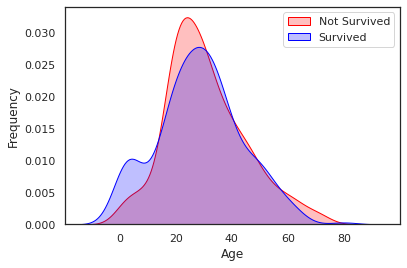

In [16]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- 두 밀도를 중첩하면 아기와 아주 어린 아이들에 해당하는 peak(0~5)를 분명히 볼 수 있다.

> Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

- 누락된 값이 하나있기 때문에 예측에 중요한 영향을 미치지 않는 중앙값으로 채우자.

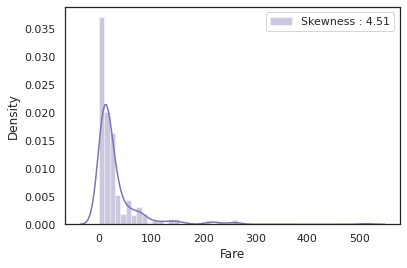

In [19]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 보다시피 Fare distribution은 매우 왜곡되어 있다. 이로 인해 크기가 조정되더라도 모델에서 매우 높은 값이 지나치게 높아질 수 있다.

- 이 경우 왜곡을 줄이기 위해 log 함수로 변환하는 것이 좋다.

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

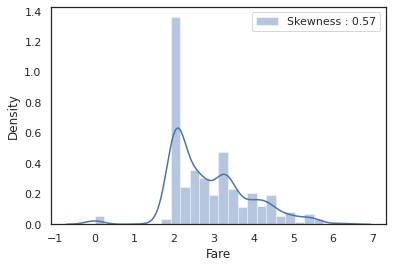

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 로그 변환 후 왜곡이 명확하게 감소한다.

###**3.2 Categorical values**

> Sex

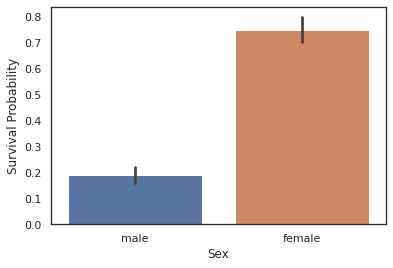

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 생존할 기회가 적다는 것은 분명하다.

- 따라서 Sex는 생존 예측에 중요한 역할을 할 수 있다.

- 타이타닉 영화(1997)를 본 사람들은 대피할 때 "Women and children first"을 기억할 것이다.

> Pclass

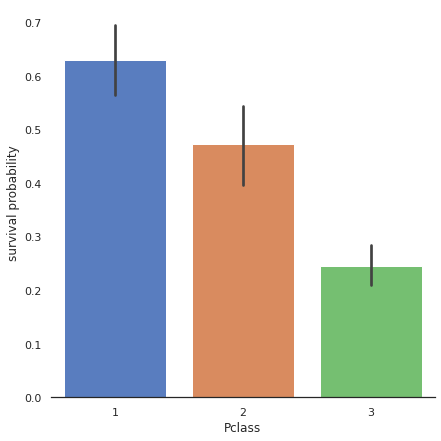

In [24]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

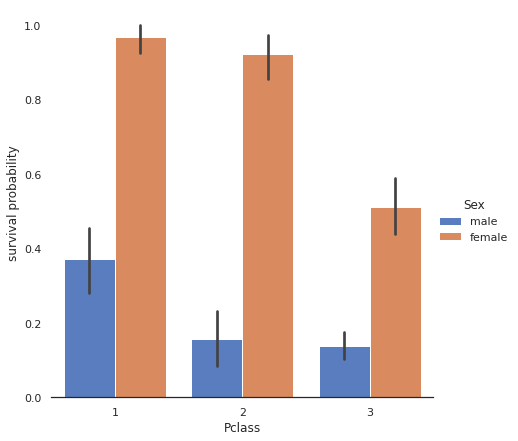

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 승객 생존율은 3개의 Pclass에서 같지 않다. 1등석 승객이 2등석 및 3등석 승객보다 생존 기회가 더 많다.

- 이 추세는 남성 승객과 여성 승객 모두를 볼 때도 마찬가지이다.

> Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

- 누락된 값이 두 개이기에 가장 빈번한 Embarked 값(S)으로 채우자.

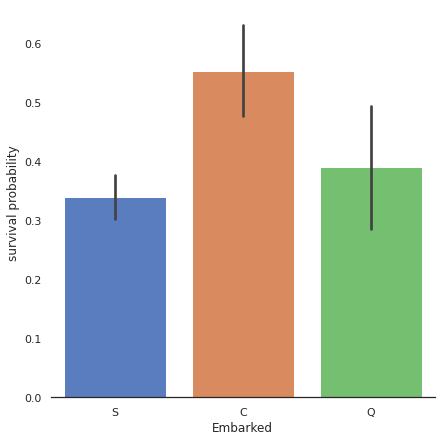

In [28]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- Cherbourg(C)에서 오는 승객이 생존할 기회가 더 많은 것 같다.

- 세우고자 하는 가설은 Queenstown(Q), Southampton(S)보다 Cherbourg(C)에서 온 승객의 일등석 비율이 더 높다는 것이다.

- Pclass 분포와 Embarked를 보자.

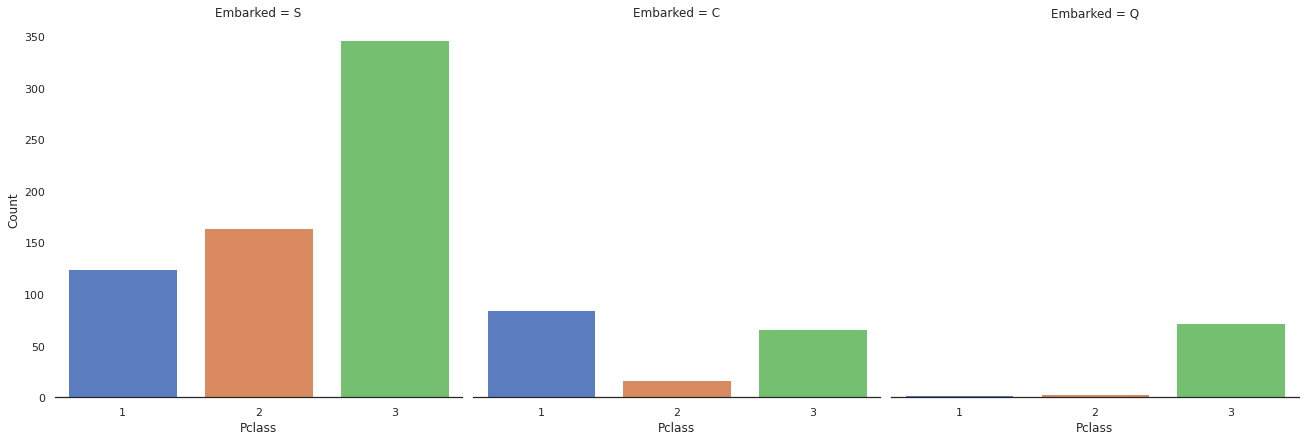

In [29]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- 실제로 3등석은 Southampton(S)과 Queenstown(Q)에서 오는 승객이 가장 빈번한 반면, Cherbourg(C) 승객은 대부분 생존율이 가장 높은 1등석이다.

- 이 시점에서 왜 1등석 승객의 생존율이 더 높은지 설명할 수 없다. 따라서 세우고자 하는 가설은 일등석 승객의 영향으로 인해 대피 중에 우선 순위가 지정되었다는 것이다.

##**4. Filling missing Values**

###**4.1 Age**
- 보다시피 Age 열에는 전체 datasets에서 256개의 누락된 값이 있다.

- 생존 가능성이 더 높은 하위 집단(ex.어린이)이 있으므로 연령 특성을 유지하고 결측값을 채우는 것이 좋다.

- 이 문제를 해결하기 위해 Age(Sex, Parch, Pclass, 및 SibSp)와 가장 관련있는 특성을 살펴보았다.

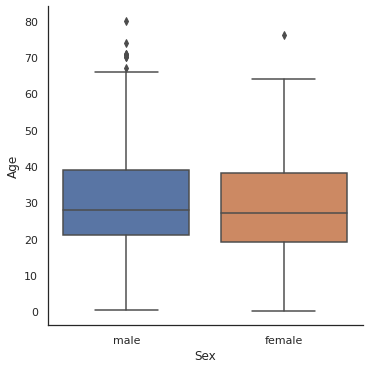

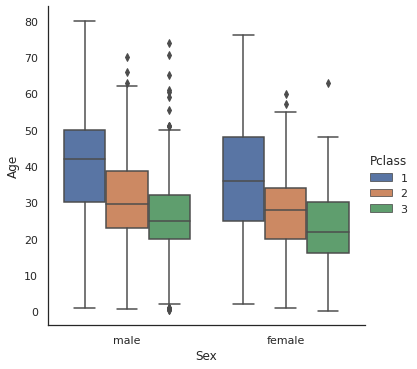

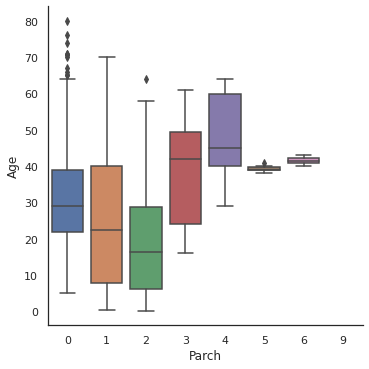

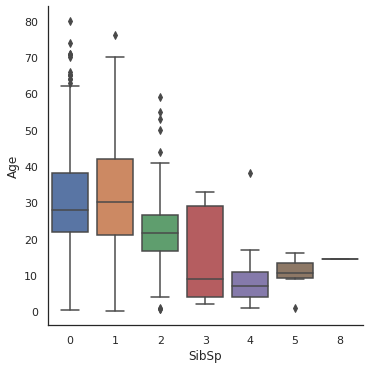

In [30]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

- Age distribution은 남성과 여성 하위 집단에서 동일한 것으로 보이므로 Sex는 Age를 예측하는 데 도움이 되지 않는다.

- 그러나 1등석 승객은 2등석 승객보다 나이가 많고, 2등석 승객은 3등석 승객보다 나이가 많다.

- 또한 승객은 부모 / 자녀가 많을수록 나이가 많고, 동생 / 배우자가 많을수록 나이가 적다.

In [31]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

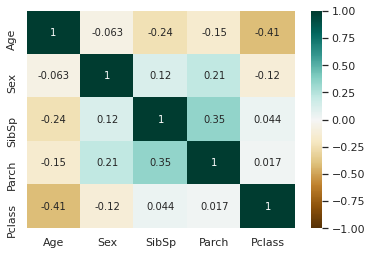

In [40]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True, vmin = -1, vmax = 1, center=0)

- Correlation map은 Parch를 제외한 factorplots observations를 확인한다. Age는 Sex와 상관이 없지만 Pclass, Parch 및 SibSp와 음의 상관관계가 있다.

- Parch 특성에 Age plot에서 Age는 부모 / 자녀의 수와 함께 성장하고 있다. 그러나 일반적인 상관관계는 음의 상관관계이다.

- 그래서 누락된 연령을 채우기 위해 SibSp, Parch 및 Pclass를 사용하기로 결정했다.

- 전략은 Pclass, Parch 및 SibSp에 따라 비슷한 행의 중간 연령으로 Age를 채우는 것이다.


> **그룹별 카운팅**
- `dataframe.groupby()` : array로 여러 개 가능
- `sns.countplot()` : Bar 형태로 각 자료의 총 개수를 보여주는 그래프 형식
- `dataframe.crosstab()` : 표 생성, 세로 필드, 가로 필드 (세로 필드를 array로 여러 개 가능)
- `sns.factorplot(x,y,hue)` : y 평균값 그래프. hue로 지정된 필드의 종류만큼 라인이 그려짐.
- `sns.violinplot(x,y,hue)` : y값의 범위와 분포를 알 수 있는 그래프
>- `sns.heatmap()` : 두 개의 카테고리 값에 대한 값 변화 파악


In [41]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

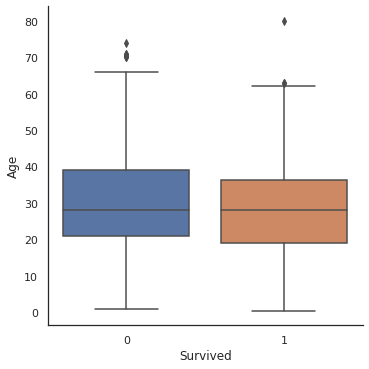

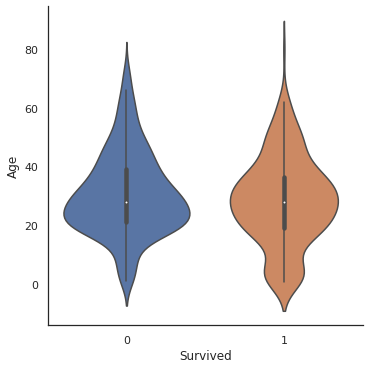

In [42]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

- 생존한 하위 집단과 생존하지 않은 하위 집단에서 연령의 중앙값 사이에는 차이가 없다.

- 그러나 살아남은 승객의 violin plot에서 여전히 아주 어린 승객의 생존율이 더 높다는 것을 알 수 있다.

##**5. Feature engineering**

###**5.1 Name / Title**

In [43]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- Name 특성은 승객의 직함에 대한 정보를 포함한다.

- 이름이 다른 승객은 대피 중에 선호될 수 있으므로 모델에 추가하는 것이 흥미롭겠다.

In [44]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

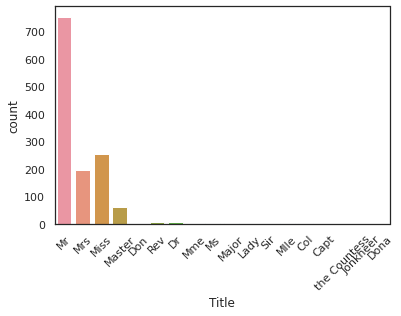

In [45]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

- Datasets에는 17개의 title이 있으며, 대부분은 매우 드물어 4개의 카테고리로 그룹화 할 수 있다.

In [46]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

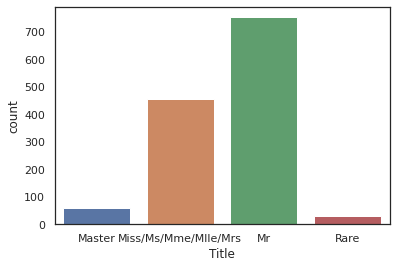

In [47]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

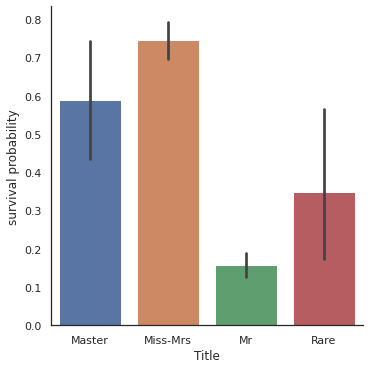

In [48]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

- "Women and children first"

- 희귀한 title을 가진 승객이 생존할 기회가 더 많다는 점이 흥미롭다.

In [49]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

###**5.2 Family size**

- 대가족이 대피하는 동안 자매 / 형제/ 부모를 찾아 대피하는데 더 많은 어려움이 있을 것이라 생각할 수 있다. 그래서 SibSp, Parch와 1의 합(승객 포함)인 "Fize(가족 크기)" 특성을 만들기로 했다.

In [50]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

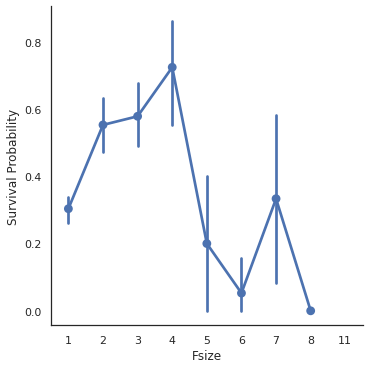

In [51]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

- 가족 규모가 중요한 역할을 하는 것으로 보이며 대가족의 경우 생존 확률이 가장 낮다.

- 가족 규모의 4가지 범주를 만들어 보자.

In [52]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

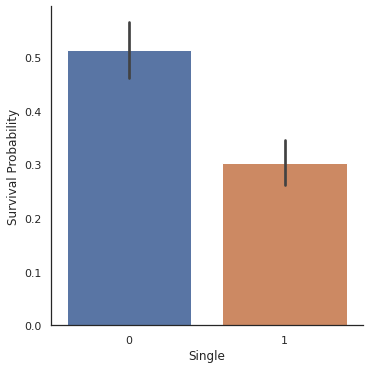

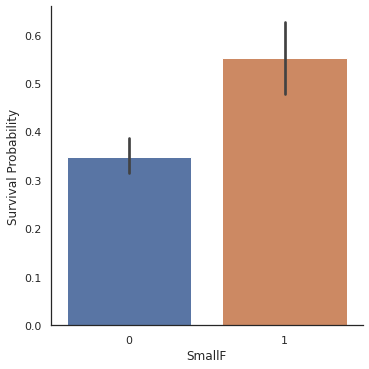

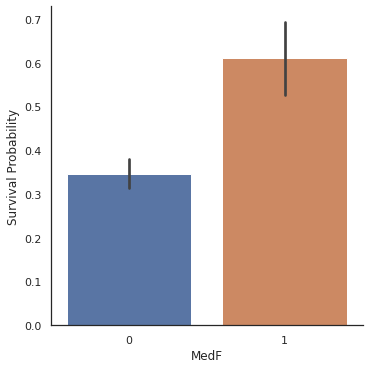

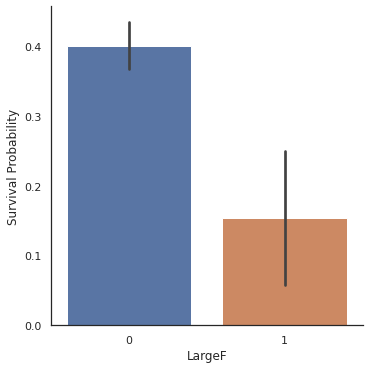

In [53]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

- 가족 규모 범주의 factorplot은 중소 가족이 1인 승객 및 대가족 보다 생존할 기회가 더 많다는 것을 보여준다.

In [54]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [55]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


- 이 단계에서는 22개의 특성이 있다.

###**5.3 Cabin**

In [56]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [57]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [58]:
dataset["Cabin"].isnull().sum()

1007

- Cabin 특성 열에는 292개의 값과 1007개의 결측 값이 존재한다.

- 객실이 없는 승객은 객실 번호 대신 누락된 값이 표시되는 것으로 가정했다.

In [59]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [60]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

- 객실의 첫 글자는 Desk를 나타내며, 타이타닉에서 승객의 가능한 위치를 나타내기 때문에 이 정보만 유지하자.

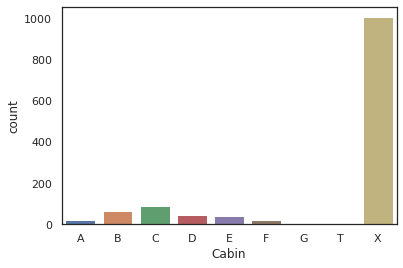

In [61]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

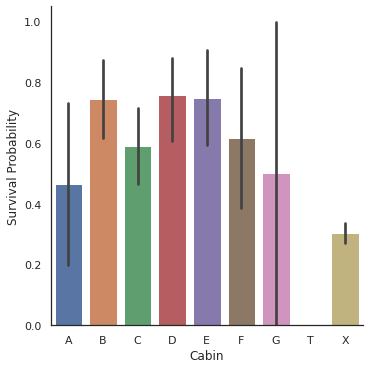

In [62]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

- 객실이 있는 승객 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지며 다른 Desk에 있는 승객의 생존 확률을 구분할 수 없다.

- 그러나 일반적으로 객실이 있는 승객이 없는 승객(X)보다 생존 가능성이 더 높다는 것을 볼 수 있다.

- 특히 B, C, D, E, F가 이에 해당한다.

In [63]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

###**5.4 Ticket**

In [64]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 이는 동일한 접두사를 공유하는 ticket이 함께 배치된 객실에 대해 예약될 수 있음을 의미할 수 있다. 따라서 선박 내 선실의 실제 배치로 이어질 수 있다.

- 동일한 접두사가 있는 ticket은 비슷한 등급의 좌석과 생존률을 가질 수 있다.

- 그래서 Ticket 특성 열을 ticket 접두사로 바꾸어 더 유익하게 할 것이다.

In [65]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [66]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [67]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [68]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [69]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


##**6. MODELING**

In [70]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [71]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

###**6.1 Simple modeling**

#### 6.1.1 Cross validate models

10개의 인기있는 분류기를 비교하고 계층화된 kfold 교차 검증 절차를 통해 각각의 평균 정확도를 평가했다.

- SVC

- Decision Tree

- AdaBoost

- Random Forest

- Extra Trees

- Gradient Boosting

- Multiple layer perceprton (neural network)

- KNN

- Logistic regression

- Linear Discriminant Analysis

In [72]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

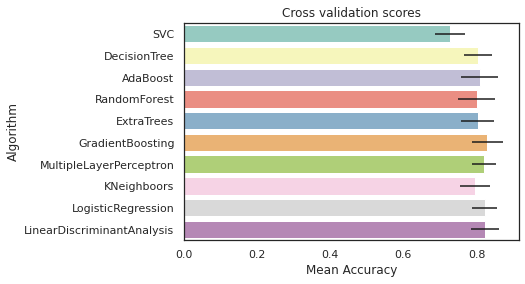

In [73]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- Ensemble modeling을 위해 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting classifier를 선택하기로 결정했다.

####6.1.2 Hyperparameter tunning for best models

- SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기에 대한 grid search 최적화를 수행했다.

- 4 cpu가 있으므로 `n_jobs` 매개 변수를 4로 설정했다. 계산 시간이 분명히 줄어든다.

- 그러나 이 단계는 시간이 오래 걸릴 수 있다.

In [85]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 644 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   15.5s finished


0.82073544433095

In [86]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.3min finished


0.8297242083758938

In [87]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.5min finished


0.8308861082737486

In [88]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.6min finished


0.8286133810010214

In [89]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.3min finished


0.8331332992849847

####6.1.3 Plot learning curves

- 학습 곡선은 training set에 대한 과적합 효과와 정확도에 대한 훈련 크기의 영향을 확인하는 좋은 방법이다.

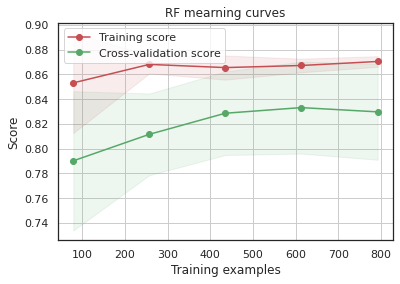

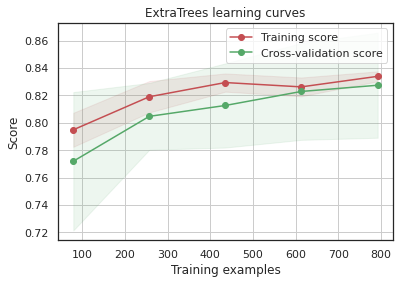

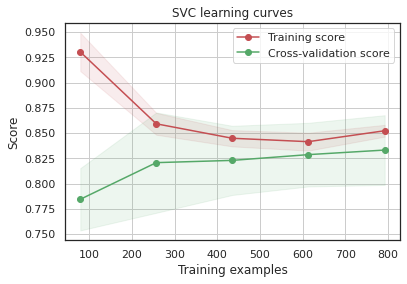

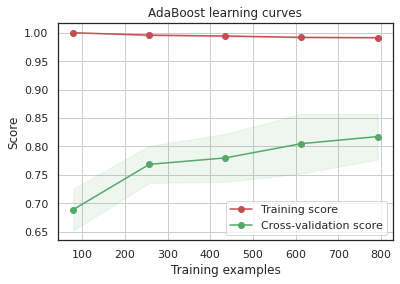

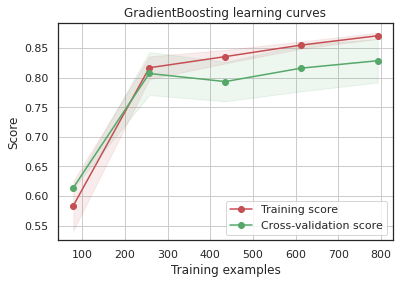

In [91]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting, Adaboost 분류기는 training set를 과도하게 맞추는 경향이 있다. 증가하는 교차 검증 곡선에 따르면 GradientBoosting과 Adaboost는 더 많은 training examples를 통해 더 잘 수행할 수 있다.

- SVC, ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같다.

####6.1.4 Feature importance of tree based classifiers

- 승객 생존 예측을 위한 가장 유익한 특성을 보기 위해 4개의 tree 기반 분류기의 특성 중요성을 표시했다.

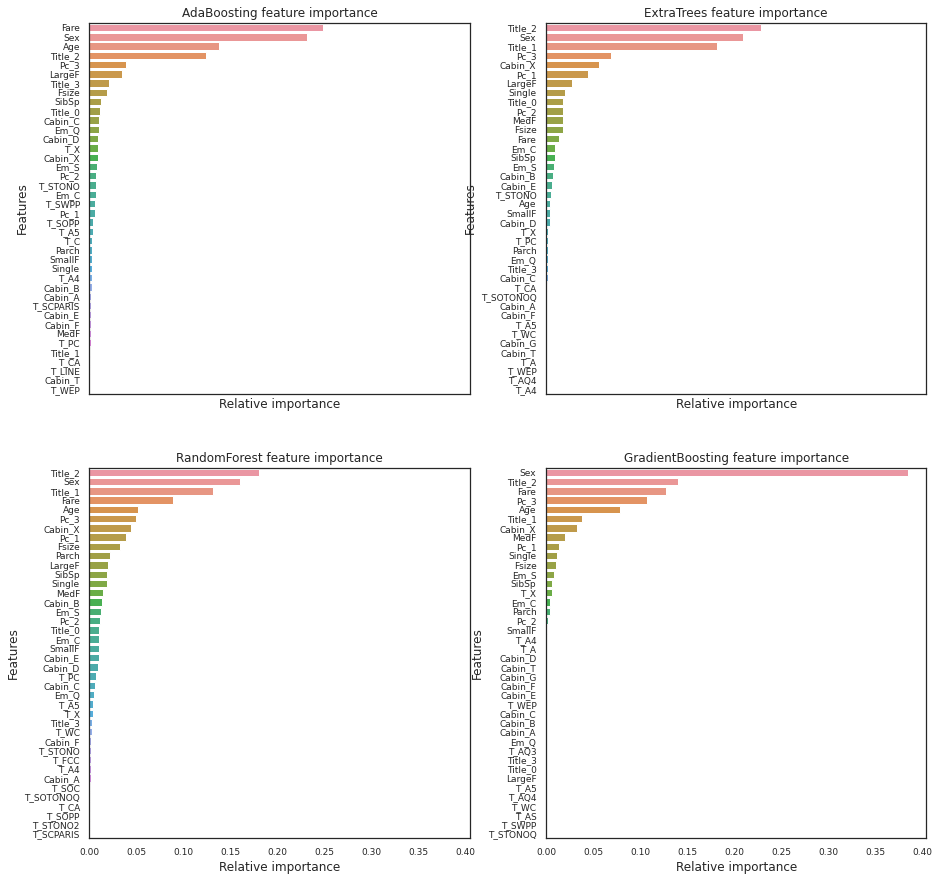

In [92]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- 4개의 tree 기반 분류기(Adabosst, ExtraTrees, RandomForest, GradientBoosting)에 대한 특성 중요성을 ploting한다.

- 4개의 분류기는 상대적 중요도에 따라 상위 특성이 다르다. 이는 예측이 동일한 특성을 기반으로 하지 않음을 의미한다. 그럼에도 불구하고 'Fare', 'Title_2', 'Age', 'Sex'와 같이 분류에 대한 몇 가지 공통된 중요한 특성을 공유한다.

- Mrs / Mlle / Mme / Miss / Ms 범주를 나타내는 Title_2는 성별과 높은 상관 관계가 있다.

- 다음과 같이 말할 수 있다.

  - Pc_1, Pc_2, Pc_3, Fare은 승객의 일반적인 사회적 지위를 나타낸다.

  - Sex 및 Title_2(Mrs / Mlle / Mme / Miss / Ms), Title_3(Mr)은 성별을 나타낸다.

  - Age, Title_1(Master)은 승객의 연령을 나타낸다.

  - Fsize, LargeF, MedF, Single은 승객 가족의 규모를 나타낸다.
  

- **이 4가지 분류기의 특성 중요성에 따르면 생존 예측은 보트의 위치보다 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련있는 것으로 보인다.**

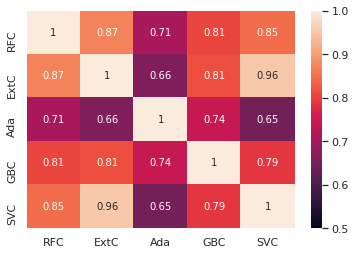

In [95]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True, vmin=0.5)

- Adaboost가 다른 분류기와 비교할 때를 제외하고는 5개의 분류기에 대해 예측이 매우 유사해 보인다.

- 5개의 분류기는 어느 정도 동일한 예측을 제공하지만 약간의 차이가 있다. 5개의 분류기 예측간의 이러한 차이점은 ensembling vote를 고려하기에 충분하다.

###**6.2 Ensemble modeling**

####6.2.1 Combining models

- 5개의 분류기에서 나오는 예측을 결합하기 위해 voting classifier를 선택했다.

- 각 vote 확률을 고려하기 위해 voting parameter에 "soft" 인수를 전달하는 것을 선호했다.

In [96]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

###**6.3 Prediction**

####6.3.1 Predict and Submit results

In [97]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("/content/drive/MyDrive/Colab Notebooks/Connection/Kaggle 필사/titanic_update/ensemble_python_voting(2).csv",index=False)